# Capstone Project - The Battle of Neighborhoods

### Introduction

The goal of this study is to give insights to a real state investor from Manhattan. Which areas are the best to invest accroding to your needs? Which is the main characteristics of the real state market in every neighbourhood?

### Business Problem

Let's say you are a real state investor that wants to focus their next steps in the New York area, but first you want to know which areas fit best your appetite. Maybe you are more focused in suburban areas with low price per square meter, or maybe you are into the luxury segment and want to know which places the high end clients prefer.

With this study, we'll categorize neighbourhoods into different clusters that will describe which kind of investment fits them better.

### Data

We use the data provided in the Kaggle repository _NYC Property Sales_:

[NYC Property Sales](https://www.kaggle.com/new-york-city/nyc-property-sales)

The data will be used in this fashion:

+ Clean the data, with focus in the 'NEIGHBORHOOD' and 'SALE PRICE' columns
+ Assign latitude and longitude coordinates to each row, so we can apply _Four Square_ API
+ Build the dataframe that correlates main characteristics of real state sales to each neighbourhood.

#### Example

Import of all necessary packages for data treatment

In [1]:
import pandas as pd
import numpy as np
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

import folium # plotting library

# import k-means from clustering stage
from sklearn.cluster import KMeans

I read the _csv_ file downloaded for Kaggle

In [2]:
ny_sales_df = pd.read_csv('nyc-rolling-sales.csv')
ny_sales_df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


Drop all non-business related columns.

In [3]:
ny_sales_df.drop(['Unnamed: 0', 'BOROUGH', 'BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','BLOCK',
                  'LOT','EASE-MENT','BUILDING CLASS AT PRESENT','ADDRESS','APARTMENT NUMBER','ZIP CODE',
                 'TAX CLASS AT TIME OF SALE','BUILDING CLASS AT TIME OF SALE','SALE DATE', 'TOTAL UNITS'], axis = 1, inplace= True)

We see that some rows in 'SALE PRICE' and others column have non-numeric values, so we'll drop those.

In [20]:
drop_price = ny_sales_df['SALE PRICE'] == ' -  ' 
ny_sales_df.drop(ny_sales_df.index[drop_price], inplace=True)
ny_sales_df['SALE PRICE'] = pd.to_numeric(ny_sales_df['SALE PRICE'])

drop_price = ny_sales_df['LAND SQUARE FEET'] == ' -  ' 
ny_sales_df.drop(ny_sales_df.index[drop_price], inplace=True)
ny_sales_df['LAND SQUARE FEET'] = pd.to_numeric(ny_sales_df['LAND SQUARE FEET'])

drop_price = ny_sales_df['GROSS SQUARE FEET'] == ' -  ' 
ny_sales_df.drop(ny_sales_df.index[drop_price], inplace=True)
ny_sales_df['GROSS SQUARE FEET'] = pd.to_numeric(ny_sales_df['GROSS SQUARE FEET'])

ny_sales_df.dropna(axis = 0, inplace=True)
ny_sales_df = ny_sales_df.reset_index(drop=True)
ny_sales_df.shape

(48244, 7)

The _describe_ method shows that there are no NaN's, but there are 0's that we will remove.

In [21]:
ny_sales_df.describe()

,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,48244.000000,48244.000000,4.824400e+04,4.824400e+04,48244.000000,4.824400e+04
mean,2.566537,0.249171,3.358117e+03,3.669753e+03,1827.765173,1.153281e+06
std,17.465481,10.988072,3.143590e+04,2.947491e+04,464.361153,1.340131e+07
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,1.000000,0.000000,1.413000e+03,8.280000e+02,1920.000000,8.042000e+04
50%,1.000000,0.000000,2.140000e+03,1.620000e+03,1931.000000,4.800000e+05
75%,2.000000,0.000000,3.071000e+03,2.520000e+03,1961.000000,8.300000e+05
max,1844.000000,2261.000000,4.228300e+06,3.750565e+06,2017.000000,2.210000e+09


In [22]:
drop_price = ny_sales_df['SALE PRICE'] == 0
ny_sales_df.drop(ny_sales_df.index[drop_price], inplace=True)

drop_price = ny_sales_df['LAND SQUARE FEET'] == 0
ny_sales_df.drop(ny_sales_df.index[drop_price], inplace=True)

drop_price = ny_sales_df['GROSS SQUARE FEET'] == 0
ny_sales_df.drop(ny_sales_df.index[drop_price], inplace=True)


ny_sales_df = ny_sales_df.reset_index(drop=True)
ny_sales_df.shape

(29329, 7)

In [23]:
ny_sales_df.describe()

,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,29329.000000,29329.000000,2.932900e+04,2.932900e+04,29329.000000,2.932900e+04
mean,3.050019,0.329401,4.328391e+03,4.625559e+03,1940.044018,1.639177e+06
std,20.021885,14.017168,3.962458e+04,3.417048e+04,47.069862,1.699539e+07
min,0.000000,0.000000,2.000000e+02,1.200000e+02,0.000000,1.000000e+00
25%,1.000000,0.000000,2.000000e+03,1.361000e+03,1920.000000,4.200000e+05
50%,2.000000,0.000000,2.500000e+03,1.874000e+03,1930.000000,6.200000e+05
75%,2.000000,0.000000,4.000000e+03,2.679000e+03,1960.000000,9.500000e+05
max,1844.000000,2261.000000,4.228300e+06,3.750565e+06,2017.000000,2.210000e+09


We see that 75% of prices are below USD 950.000, with outlayers in the billion range

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000222D39C4C48>]],
      dtype=object)

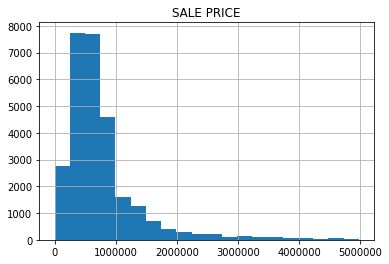

In [24]:
ny_sales_df[ny_sales_df['SALE PRICE'] < 5e06].hist(column = ['SALE PRICE'], bins = 20)

We will build the address variable by adding the ' New York, NY' string to the 'ADDRESS' column

In [25]:
address = ny_sales_df['NEIGHBORHOOD'].unique() + ', New York, NY'
address

array(['ALPHABET CITY, New York, NY', 'CHELSEA, New York, NY',
       'CHINATOWN, New York, NY', 'CIVIC CENTER, New York, NY',
       'CLINTON, New York, NY', 'EAST VILLAGE, New York, NY',
       'FASHION, New York, NY', 'FINANCIAL, New York, NY',
       'FLATIRON, New York, NY', 'GRAMERCY, New York, NY',
       'GREENWICH VILLAGE-CENTRAL, New York, NY',
       'GREENWICH VILLAGE-WEST, New York, NY',
       'HARLEM-CENTRAL, New York, NY', 'HARLEM-EAST, New York, NY',
       'HARLEM-UPPER, New York, NY', 'HARLEM-WEST, New York, NY',
       'INWOOD, New York, NY', 'JAVITS CENTER, New York, NY',
       'KIPS BAY, New York, NY', 'LITTLE ITALY, New York, NY',
       'LOWER EAST SIDE, New York, NY', 'MANHATTAN VALLEY, New York, NY',
       'MIDTOWN CBD, New York, NY', 'MIDTOWN EAST, New York, NY',
       'MIDTOWN WEST, New York, NY', 'MURRAY HILL, New York, NY',
       'ROOSEVELT ISLAND, New York, NY', 'SOHO, New York, NY',
       'SOUTHBRIDGE, New York, NY', 'TRIBECA, New York, NY',
       

Finally, with the address variable we can use _geolocator_ to get the latitude and longitude of each address. Beware, this piece of code is time-consuming!

In [26]:
# address = 'ALPHABET CITY, New York, NY'
geolocator = Nominatim(user_agent="foursquare_agent")
latitude = np.zeros(len(address), 'float32')
longitude = np.zeros(len(address), 'float32')
i=0
for loc in address:
        location = geolocator.geocode(loc, timeout=20)
        if location is not None:
            latitude[i] = location.latitude
            longitude[i] = location.longitude
        i=i+1


Every Neighborhood with its latitude and longitude

In [27]:
df2 = pd.DataFrame()
df2['NEIGHBORHOOD'] = ny_sales_df['NEIGHBORHOOD'].unique()
df2['latitude'] = latitude
df2['longitude'] = longitude
df2

,NEIGHBORHOOD,latitude,longitude
0,ALPHABET CITY,40.725101,-73.979584
1,CHELSEA,40.746490,-74.001526
2,CHINATOWN,40.716492,-73.996254
3,CIVIC CENTER,40.712727,-74.006012
4,CLINTON,43.048405,-75.378502
...,...,...,...
245,TRAVIS,40.593159,-74.187920
246,WEST NEW BRIGHTON,40.634548,-74.112083
247,WESTERLEIGH,40.621216,-74.131813
248,WILLOWBROOK,40.603161,-74.138474


I join main dataframe with neighborhood by latitude

In [28]:
ny_sales_df = ny_sales_df.join(df2.set_index('NEIGHBORHOOD'), on='NEIGHBORHOOD')
non_lat = ny_sales_df['latitude']==0
ny_sales_df.drop(ny_sales_df.index[non_lat], inplace=True)
ny_sales_df.head()

,NEIGHBORHOOD,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,latitude,longitude
0,ALPHABET CITY,5,0,1633,6440,1900,6625000,40.725101,-73.979584
1,ALPHABET CITY,10,0,2272,6794,1913,3936272,40.725101,-73.979584
2,ALPHABET CITY,6,0,2369,4615,1900,8000000,40.725101,-73.979584
3,ALPHABET CITY,8,0,1750,4226,1920,3192840,40.725101,-73.979584
4,ALPHABET CITY,24,0,4489,18523,1920,16232000,40.725101,-73.979584


I save in case I need it later, so don't have to run all code

In [215]:
ny_sales_df.to_csv('ny_sales_df.csv')

In [4]:
ny_sales_df=pd.read_csv('ny_sales_df.csv')

I represent points on the map

In [34]:
ny_map = folium.Map(location=[df2['latitude'][0], df2['longitude'][0]], zoom_start=10) # generate map centred around the Conrad Hotel

for lat, lng, borough in zip(df2['latitude'], df2['longitude'], df2['NEIGHBORHOOD']):
    label = '{}'.format(borough)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
#         popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(ny_map)  


ny_map

I perform a Z-Score to the data frame.

In [5]:
ny_sales_norm_df = ny_sales_df

ny_sales_norm_df['RESIDENTIAL UNITS'] = (ny_sales_df['RESIDENTIAL UNITS']-ny_sales_df['RESIDENTIAL UNITS'].mean())/ny_sales_df['RESIDENTIAL UNITS'].std()
ny_sales_norm_df['COMMERCIAL UNITS'] = (ny_sales_df['COMMERCIAL UNITS']-ny_sales_df['COMMERCIAL UNITS'].mean())/ny_sales_df['COMMERCIAL UNITS'].std()
ny_sales_norm_df['LAND SQUARE FEET'] = (ny_sales_df['LAND SQUARE FEET']-ny_sales_df['LAND SQUARE FEET'].mean())/ny_sales_df['LAND SQUARE FEET'].std()
ny_sales_norm_df['GROSS SQUARE FEET'] = (ny_sales_df['GROSS SQUARE FEET']-ny_sales_df['GROSS SQUARE FEET'].mean())/ny_sales_df['GROSS SQUARE FEET'].std()
ny_sales_norm_df['YEAR BUILT'] = (ny_sales_df['YEAR BUILT']-ny_sales_df['YEAR BUILT'].mean())/ny_sales_df['YEAR BUILT'].std()
ny_sales_norm_df['SALE PRICE'] = (ny_sales_df['SALE PRICE']-ny_sales_df['SALE PRICE'].mean())/ny_sales_df['SALE PRICE'].std()

ny_sales_norm_df

,Unnamed: 0,NEIGHBORHOOD,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,latitude,longitude
0,0,ALPHABET CITY,0.100272,-0.023051,-0.071155,0.061013,-0.832467,0.458997,40.725100,-73.97958
1,1,ALPHABET CITY,0.346626,-0.023051,-0.053745,0.071636,-0.560896,0.217127,40.725100,-73.97958
2,2,ALPHABET CITY,0.149543,-0.023051,-0.051102,0.006252,-0.832467,0.582688,40.725100,-73.97958
3,3,ALPHABET CITY,0.248084,-0.023051,-0.067967,-0.005421,-0.414665,0.150250,40.725100,-73.97958
4,4,ALPHABET CITY,1.036419,-0.023051,0.006658,0.423579,-0.414665,1.323216,40.725100,-73.97958
...,...,...,...,...,...,...,...,...,...,...
27395,29324,WOODROW,-0.047541,-0.023051,-0.050257,-0.054961,1.214761,-0.096489,40.543438,-74.19765
27396,29325,WOODROW,-0.047541,-0.023051,-0.047587,-0.060902,1.214761,-0.087493,40.543438,-74.19765
27397,29326,WOODROW,-0.047541,-0.023051,-0.006665,-0.087338,-0.310215,-0.095589,40.543438,-74.19765
27398,29327,WOODROW,-0.146083,0.459812,5.552296,1.791686,1.277432,0.914930,40.543438,-74.19765


I group by neighborhood

In [6]:
ny_sales_mean_df = ny_sales_norm_df.groupby('NEIGHBORHOOD', as_index = False).mean()
ny_sales_mean_df

,NEIGHBORHOOD,Unnamed: 0,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,latitude,longitude
0,AIRPORT LA GUARDIA,13189.0,-0.027833,-0.023051,-0.057744,-0.075383,0.257996,-0.075124,40.775715,-73.87337
1,ALPHABET CITY,5.0,0.297355,0.002033,-0.048576,0.102343,-0.435555,0.510731,40.725100,-73.97958
2,ANNADALE,24319.5,-0.081135,-0.021796,0.017222,-0.068912,0.888876,-0.081720,40.544548,-74.17653
3,ARROCHAR,24611.5,-0.076282,-0.014428,-0.016864,-0.068813,0.821332,-0.085918,40.598440,-74.07264
4,ARVERNE,13259.0,-0.058125,-0.022029,-0.032317,-0.071712,0.572430,-0.101734,40.593420,-73.78954
...,...,...,...,...,...,...,...,...,...,...
220,WOODHAVEN,24030.0,-0.059387,-0.019445,-0.048340,-0.074195,-0.431916,-0.083679,40.689270,-73.85791
221,WOODLAWN,4497.5,0.028829,-0.019601,-0.012508,-0.003436,-0.299247,-0.051804,40.895752,-73.86245
222,WOODROW,29281.5,-0.080563,-0.017180,0.055149,-0.053093,1.106755,-0.076934,40.543438,-74.19765
223,WOODSIDE,24219.0,0.031509,-0.003342,-0.039419,-0.014112,0.003825,0.003985,40.745380,-73.90541


Apply K-means algortihm.

In [7]:
# set number of clusters
kclusters = 10

ny_sales_clustering = ny_sales_mean_df.drop(['NEIGHBORHOOD','latitude', 'longitude'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_sales_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100]

array([9, 3, 0, 0, 9, 9, 1, 3, 1, 3, 2, 1, 2, 2, 2, 3, 7, 7, 7, 7, 2, 7,
       2, 3, 3, 7, 7, 0, 7, 2, 7, 7, 0, 3, 3, 3, 3, 3, 7, 0, 3, 7, 7, 2,
       0, 0, 7, 2, 3, 3, 7, 7, 0, 0, 2, 7, 2, 7, 3, 3, 3, 2, 0, 0, 2, 3,
       3, 3, 4, 4, 4, 3, 4, 2, 2, 5, 3, 5, 4, 0, 5, 4, 5, 5, 4, 3, 0, 0,
       4, 0, 0, 4, 3, 3, 0, 5, 3, 3, 3, 3])

In [8]:
# add clustering labels
ny_sales_mean_df['Cluster Labels'] = kmeans.labels_

In [221]:
# create map
map_clusters = folium.Map(location=[latitude[0], longitude[0]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_sales_mean_df['latitude'], ny_sales_mean_df['longitude'], ny_sales_mean_df['NEIGHBORHOOD'], ny_sales_mean_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

I show the main characteristics of every cluster.

In [223]:
ny_sales_mean_df.drop(['latitude', 'longitude'], axis = 1).groupby('Cluster Labels').mean()

,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
Cluster Labels,,,,,,
0,-0.076669,-0.014816,0.024778,-0.059899,0.635396,-0.084291
1,3.405901,2.598201,0.390365,13.230329,0.261414,21.382825
2,0.358508,0.041087,-0.006520,0.228732,-0.502612,0.570890
3,1.807157,0.834276,0.114838,4.213276,0.035964,8.926857
4,-0.146083,0.045930,9.147790,-0.003200,0.441828,-0.136968
5,-0.021957,0.003666,-0.003068,-0.030935,-0.119977,-0.034015
6,0.813605,0.092065,0.053578,0.887521,-0.338234,1.297307
7,0.056475,0.264367,0.147588,2.269567,-0.107117,5.683085
8,4.719419,1.529007,0.340317,2.819208,0.097142,7.178048


And how many neighborhoods there are in every cluster.

In [233]:
ny_sales_mean_df.drop(['latitude', 'longitude'], axis = 1).groupby('Cluster Labels').count()

,NEIGHBORHOOD,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
Cluster Labels,,,,,,,
0,52,52,52,52,52,52,52
1,1,1,1,1,1,1,1
2,23,23,23,23,23,23,23
3,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1
5,124,124,124,124,124,124,124
6,17,17,17,17,17,17,17
7,2,2,2,2,2,2,2
8,1,1,1,1,1,1,1
